### [Hand] Ego Pose Visualization

In this notebook you can visualize the hand ego pose annotation. Please make sure you have followed instructions in README.md to get the ground truth JSON file and undistorted Aria images. Some notes about directories to be used:

- `<egoexo_output_dir>`: Directory of the data downloaded by Ego-Exo4D Downloader.
- `<gt_output_dir>`: Output directory of hand ego pose data preparation script.

#### Setup

In [1]:
import cv2
import json
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from utils.utils import get_ego_aria_cam_name, cam_to_img

In [3]:
egoexo_output_dir = "/workspace/project/ego-exo_data" # MODIFY
gt_output_dir = "/workspace/project/ego-exo_gt_data" # MODIFY

# Choose split and annotation type
split = "train"  # MODIFY
anno_type = "manual"    # MODIFY
orientation = "landscape" # MODIFY

assert split in ["train", "val", "test"], f"Invalid split: {split}"
assert anno_type in ["manual", "auto"], f"Invalid anno_type: {anno_type}"
assert orientation in ["landscape", "portrait"], f"Invalid orientation: {orientation}"

In [4]:
# Load in train split ground truth annotation
if split in ["train", "val"]:
    gt_anno_path = os.path.join(gt_output_dir, f"annotation/{anno_type}/ego_pose_gt_anno_{split}_public.json")
else:
    gt_anno_path = os.path.join(gt_output_dir, f"annotation/{anno_type}/ego_pose_gt_anno_{split}_private.json")
assert os.path.exists(gt_anno_path), f"{gt_anno_path} doesn't exist"
gt_anno = json.load(open(gt_anno_path))

# Load in takes metadata
takes = json.load(open(os.path.join(egoexo_output_dir, "takes.json")))

# camera pose and parameters
cam_pose_dir = os.path.join(egoexo_output_dir, f"annotations/ego_pose/{split}/camera_pose")

# Undistorted Aria image directory
img_view_prefix = "image_portrait_view" if orientation == "portrait" else "image"
img_dir = os.path.join(gt_output_dir, f"{img_view_prefix}/undistorted/{split}")

# take uid dict
take_to_uid = {each_take['take_name'] : each_take['take_uid'] for each_take in takes if each_take["take_uid"] in gt_anno.keys()}
uid_to_take = {uid:take for take, uid in take_to_uid.items()}

# Helper function for visualization
def vis_2d_bbox(img, two_hands_bbox, take_name, frame_idx, label=""):
    assert isinstance(two_hands_bbox, dict) and len(two_hands_bbox) == 2

    ## Plot
    plt.figure(figsize=(5,5))
    plt.imshow(img)
    for _, one_hand_bbox in two_hands_bbox.items():
        if len(one_hand_bbox) > 0:
            plt.plot([one_hand_bbox[0],one_hand_bbox[2]], [one_hand_bbox[1],one_hand_bbox[1]], 'r')
            plt.plot([one_hand_bbox[0],one_hand_bbox[0]], [one_hand_bbox[1],one_hand_bbox[3]], 'r')
            plt.plot([one_hand_bbox[0],one_hand_bbox[2]], [one_hand_bbox[3],one_hand_bbox[3]], 'r')
            plt.plot([one_hand_bbox[2],one_hand_bbox[2]], [one_hand_bbox[1],one_hand_bbox[3]], 'r')
    plt.title(f"{label} {take_name} - frame_idx={frame_idx}", fontsize=10)
    plt.axis("off")

def vis_2d_hand_pose(img, two_hand_kpts_2d, take_name, frame_idx, label=""):
    ## Vis index misc ###
    finger_index = np.array([[0,1,2,3,4],
                             [0,5,6,7,8],
                             [0,9,10,11,12],
                             [0,13,14,15,16],
                             [0,17,18,19,20]])
    color_dict = {0:'tab:blue', 1:'tab:orange', 2:'tab:green', 3:'tab:red', 4:'tab:purple'}
    assert isinstance(two_hand_kpts_2d, dict) and len(two_hand_kpts_2d) == 2

    ## Plot
    plt.figure(figsize=(5,5))
    plt.imshow(img)
    for _, one_hand_kpts_2d in two_hand_kpts_2d.items():
        if len(one_hand_kpts_2d) > 0:
            for i, each_finger_index in enumerate(finger_index):
                curr_finger_kpts = one_hand_kpts_2d[each_finger_index]
                plt.plot(curr_finger_kpts[:,0], curr_finger_kpts[:,1], marker='o', markersize=2, color=color_dict[i])
    plt.title(f"{label} {take_name} - frame_idx={frame_idx}", fontsize=10)
    plt.axis("off")


def vis_3d_hand_pose(two_hand_kpts_3d):
    ## Vis index misc ###
    finger_index = np.array([[0,1,2,3,4],
                             [0,5,6,7,8],
                             [0,9,10,11,12],
                             [0,13,14,15,16],
                             [0,17,18,19,20]])
    color_dict = {0:'tab:blue', 1:'tab:orange', 2:'tab:green', 3:'tab:red', 4:'tab:purple'}
    assert isinstance(two_hand_kpts_3d, dict) and len(two_hand_kpts_3d) == 2

    fig = plt.figure(figsize=plt.figaspect(0.5))
    for i, hand_order in enumerate(["left", "right"]):
        one_hand_kpts_3d = two_hand_kpts_3d[hand_order]
        ax = fig.add_subplot(1, 2, i+1, projection='3d')
        ax.set_title(f"3D plot - {hand_order} hand")
        if len(one_hand_kpts_3d) > 0:
            for f_ith, each_finger_index in enumerate(finger_index):
                curr_finger_kpts = one_hand_kpts_3d[each_finger_index]
                ax.scatter(curr_finger_kpts[:,0], curr_finger_kpts[:,1], curr_finger_kpts[:,2], color=color_dict[f_ith])
                ax.plot3D(curr_finger_kpts[:,0], curr_finger_kpts[:,1], curr_finger_kpts[:,2], color=color_dict[f_ith])
            ax.set_xlabel("X")
            ax.set_ylabel("Y")
            ax.set_zlabel("Z")
        ax.set_aspect('equal')

#### Select takes

In [5]:
print(f"Found {len(gt_anno)} takes from {split} split:")
for uid in gt_anno:
    print(f"{uid_to_take[uid]:25s} {uid}")

Found 248 takes from train split:
nus_cooking_06_5          d1888843-9fb6-4a0b-a732-978d03786ae6
georgiatech_bike_11_7     864227f5-9937-4e42-894e-b96e59ad5e31
fair_cooking_08_8         407f60e4-68b2-42df-84a9-3160398aaf10
upenn_0721_Piano_2_2      a8d04142-fc0b-4ad4-acaa-8c17424411ff
upenn_0407_Violin_1_2     1c000f43-c516-4552-8010-9055a49763d1
fair_bike_06_7            6835b48d-ce8e-474d-b589-86d023628792
nus_cpr_25_2              58004f8a-fd60-4db6-8145-5125a4cd346f
cmu_bike01_7              6f942bbd-acc8-4ec1-8758-89029b391cda
upenn_0331_Guitar_4_5     5dad1edc-bcaa-4ad3-b091-cd9b01917f47
upenn_0407_Violin_1_5     03672458-fd03-4e1e-9754-776175089ab0
iiith_cooking_118_2       a6c76788-37ca-4005-9e7e-cf5ecb00d8cf
fair_bike_01_2            02715c86-e30c-4791-92b7-38b488e51aba
iiith_cooking_124_2       3655a8a0-38fc-4be9-ab20-32448b48abb1
cmu_bike19_4              a91ef958-df79-4905-8469-37c552c11441
georgiatech_covid_09_6    f7919017-3bd3-4c92-8f7f-ce9b33f07353
cmu_bike08_5         

In [6]:
vis_take_name = "upenn_0717_Piano_1_2" # MODIFY

# Get selected take's annotation
vis_take_anno = gt_anno[take_to_uid[vis_take_name]]
print(f"Found {len(vis_take_anno)} images from {vis_take_name} with annotated frame number:")
# Print all annotated frames
print(list(vis_take_anno.keys()))

# Load aria cam name and cam pose
take = [t for t in takes if t['take_name'] == vis_take_name][0]
aria_name = get_ego_aria_cam_name(take)
curr_uid = take_to_uid[vis_take_name]
curr_cam_pose = json.load(open(os.path.join(cam_pose_dir, f"{curr_uid}.json")))

Found 298 images from upenn_0717_Piano_1_2 with annotated frame number:
['102', '105', '108', '111', '114', '117', '120', '123', '126', '129', '132', '135', '141', '144', '147', '150', '153', '156', '159', '162', '165', '168', '171', '174', '177', '180', '183', '186', '189', '192', '195', '198', '201', '204', '207', '210', '213', '216', '219', '222', '225', '228', '234', '237', '240', '243', '246', '249', '252', '255', '258', '261', '264', '267', '270', '273', '276', '279', '282', '285', '291', '294', '297', '300', '303', '306', '309', '312', '315', '318', '321', '324', '327', '330', '333', '336', '339', '342', '345', '348', '351', '354', '357', '360', '363', '366', '369', '372', '375', '378', '381', '384', '387', '390', '393', '396', '399', '402', '405', '408', '411', '414', '417', '420', '423', '426', '429', '432', '435', '438', '441', '444', '447', '450', '456', '459', '462', '465', '468', '471', '474', '477', '480', '483', '486', '489', '492', '495', '498', '501', '504', '507', '51

#### Select frame_idx and visualize

Pick one annotated frame and visualize 2D annotation, 3D annotation and projected 2D annotation.

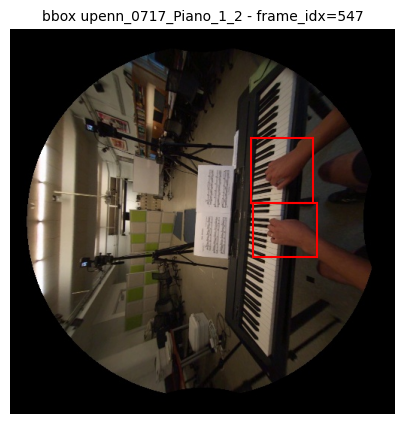

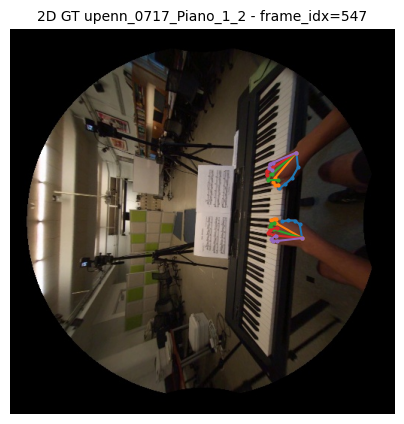

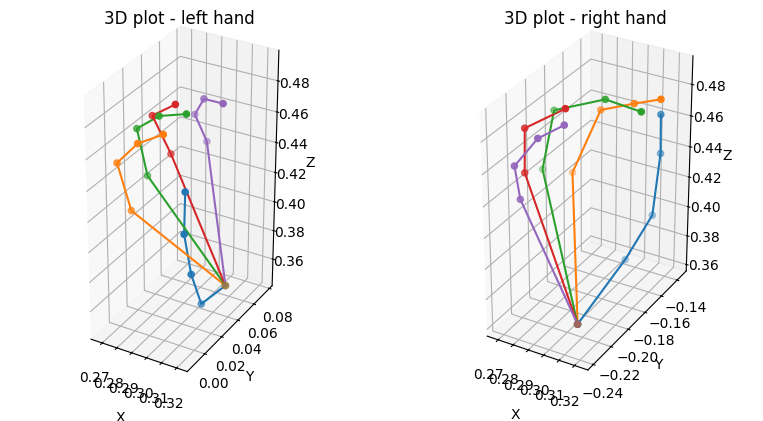

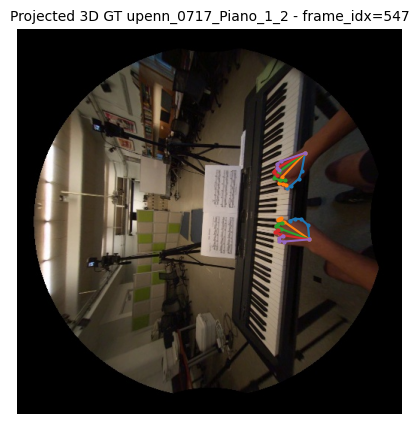

In [7]:
vis_frame_idx = 547 # MODIFY
vis_frame_idx = str(vis_frame_idx)

# Image
img = np.array(Image.open(os.path.join(img_dir, vis_take_name, f"{int(vis_frame_idx):06d}.jpg")))

## hand bounding box visualization
bbox_right = np.array(vis_take_anno[vis_frame_idx]['right_hand_bbox']).astype(np.float32)
bbox_left = np.array(vis_take_anno[vis_frame_idx]['left_hand_bbox']).astype(np.float32)
two_hands_bbox = {"right": bbox_right, "left": bbox_left}
vis_2d_bbox(img, two_hands_bbox, vis_take_name, vis_frame_idx, "bbox")

## 2D annotation visualization
kpts_2d_right = np.array(vis_take_anno[vis_frame_idx]['right_hand_2d']).astype(np.float32)
kpts_2d_left = np.array(vis_take_anno[vis_frame_idx]['left_hand_2d']).astype(np.float32)
two_hands_kpts_2d = {"right": kpts_2d_right, "left": kpts_2d_left}
vis_2d_hand_pose(img, two_hands_kpts_2d, vis_take_name, vis_frame_idx, "2D GT")

## 3D annotation visualization
kpts_3d_right = np.array(vis_take_anno[vis_frame_idx]['right_hand_3d']).astype(np.float32)
kpts_3d_left = np.array(vis_take_anno[vis_frame_idx]['left_hand_3d']).astype(np.float32)
# rotate 3D annotations if in portrait view
if orientation == "portrait":
    print(kpts_3d_right.shape)
    R = np.array([[0,-1,0], [1,0,0], [0,0,1]])
    print(R)
    kpts_3d_right = (R @ kpts_3d_right.T).T
    kpts_3d_left = (R @ kpts_3d_left.T).T
two_hands_kpts_3d = {"right": kpts_3d_right, "left": kpts_3d_left}
vis_3d_hand_pose(two_hands_kpts_3d)

## Projected 2D annotation visualization
intrinsics = np.array(curr_cam_pose[aria_name]["camera_intrinsics"]).astype(np.float32)
kpts_2d_right_proj = cam_to_img(kpts_3d_right, intrinsics) if len(kpts_3d_right) > 0 else kpts_3d_right
kpts_2d_left_proj = cam_to_img(kpts_3d_left, intrinsics) if len(kpts_3d_left) > 0 else kpts_3d_left
two_hands_kpts_2d_proj = {"right": kpts_2d_right_proj, "left": kpts_2d_left_proj}
vis_2d_hand_pose(img, two_hands_kpts_2d_proj, vis_take_name, vis_frame_idx, "Projected 3D GT")